In [1]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 16}) 

import numpy as np

import phenom

import lal
import lalsimulation as lalsim

import lalutils

In [2]:
import greedyrb
# import gprfit
import fitslr

# data acquisition

We need a function that we can call to
generate data in a uniform way.

We will use this to generate the data for:
 - the seed basis
 - additional training sets and
 - validation sets

In [3]:
def gen_fd_phenomHM_modes(m1, m2, ell, m, f_min=30, f_max=200, deltaF=1./8):
    m1_SI = m1 * lal.MSUN_SI
    m2_SI = m2 * lal.MSUN_SI
    
    chi1z = 0.
    chi2z = 0.
    phiRef = 0.
    f_ref = 0.
    
    f_array = np.arange(f_min, f_max, deltaF)
    
    freqs = lal.CreateREAL8Sequence(len(f_array))
    freqs.data = f_array
    deltaF=-1
    
    extraParams = lal.CreateDict()
    ma = lalsim.SimInspiralCreateModeArray()
    lalsim.SimInspiralModeArrayActivateMode(ma, ell, m)
    lalsim.SimInspiralWaveformParamsInsertModeArray(extraParams, ma)
    
    
    hlms = lalsim.SimIMRPhenomHMGethlmModes(
        freqs,
        m1_SI,
        m2_SI,
        chi1z,
        chi2z,
        phiRef,
        deltaF,
        f_ref,
        extraParams)
    
    hlm = lalsim.SphHarmFrequencySeriesGetMode(hlms, ell, m)
    
    hlm = hlm.data.data
    amp = np.abs(hlm)
    phase = np.unwrap(np.angle(hlm))
    
    return f_array, amp, phase

In [4]:
freq, amp, phase = gen_fd_phenomHM_modes(50, 50, 3, 2, f_max=400)

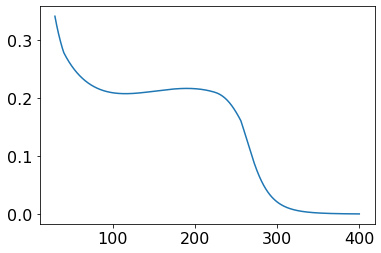

In [5]:
plt.figure()
plt.plot(freq, amp)

In [6]:
def gen_1d_massratio_data(q_array, M, ell=3, mm=2, deltaF=1/8./2/2, f_min=10, f_max=800,
                         approximant=lalsim.IMRPhenomD, inclination=0):

    data = []
    coords = []
    
    for q in q_array:
        m1, m2 = phenom.m1_m2_M_q(M, q)
#         pp = dict(m1=m1, m2=m2, deltaF=deltaF,
#                   f_min=f_min, f_max=f_max,
#                   inclination=inclination,
#                   approximant=approximant
#                  )
#         p = lalutils.gen_wf_params(**pp)
#         f, _, _, phase = lalutils.gen_wf(p)
        f, amp, phase = gen_fd_phenomHM_modes(m1, m2, ell, mm, f_min=f_min, f_max=f_max, deltaF=deltaF)
        
        d = {"f":f, "phase":phase}
#         f, _, amp, phase = lalutils.gen_wf(p)
#         d = {"f":f, "phase":phase, "amp":amp}
        data.append(d)
        coords.append([q])
    
    new_f = []
    new_y = []
    
    # subtract linear piece from phase
    for i in range(len(data)):
        
        f = data[i]['f']
        y = data[i]['phase']
#         y = data[i]['amp']
        
        mask = (f >= f_min) & (f <= f_max)
#         mask = (f >= f_min) & (f <= 100)

        z = np.polyfit(f[mask], y[mask], 1)
        p = np.poly1d(z)

        new_f.append(f)
        new_y.append(y - p(f))
#         new_f.append(f)
#         new_y.append(y)


    n_f_points = len(new_f[0])
    n_waveforms = len(new_f)
    ts = np.zeros(shape=(n_waveforms, n_f_points))
    
    x = new_f[0]
    for i in range(n_waveforms):
        ts[i] = new_y[i]
        
    return x, ts, np.array(coords)

In [7]:
def gen_1d_massratio_data(q_array, M, deltaF=1/8., f_min=30, f_max=200,
                         approximant=lalsim.IMRPhenomD, inclination=0):

    data = []
    coords = []
    
    for q in q_array:
        m1, m2 = phenom.m1_m2_M_q(M, q)
        pp = dict(m1=m1, m2=m2, deltaF=deltaF,
                  f_min=f_min, f_max=f_max,
                  inclination=inclination,
                  approximant=approximant
                 )
        p = lalutils.gen_wf_params(**pp)
        f, _, _, phase = lalutils.gen_wf(p)
        d = {"f":f, "phase":phase}
#         f, _, amp, phase = lalutils.gen_wf(p)
#         d = {"f":f, "phase":phase, "amp":amp}
        data.append(d)
        coords.append([q])
    
    new_f = []
    new_y = []
    
    # subtract linear piece from phase
    for i in range(len(data)):
        
        f = data[i]['f']
        y = data[i]['phase']
#         y = data[i]['amp']
        
#         mask = (f >= f_min) & (f <= f_max)
        mask = (f >= f_min) & (f <= f_max)

        z = np.polyfit(f[mask], y[mask], 1)
        p = np.poly1d(z)

        new_f.append(f)
        new_y.append(y - p(f))
#         new_f.append(f)
#         new_y.append(y)


    n_f_points = len(new_f[0])
    n_waveforms = len(new_f)
    ts = np.zeros(shape=(n_waveforms, n_f_points))
    
    x = new_f[0]
    for i in range(n_waveforms):
        ts[i] = new_y[i]
        
    return x, ts, np.array(coords)

In [8]:
seed_x, seed_ts, seed_ts_coords = gen_1d_massratio_data(np.linspace(1,10,3), 100)

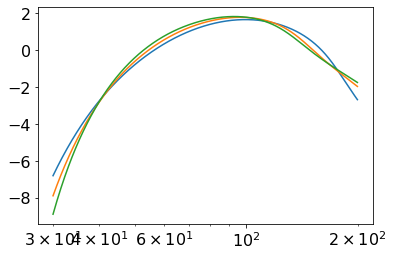

In [9]:
plt.figure()
for s in seed_ts:
    plt.plot(seed_x, s)
plt.xscale('log')

# surrogate class

In [10]:
# Make integration rule

int_range = [seed_x[0], seed_x[-1]]
int_num = len(seed_x)

integration = greedyrb.Riemann(int_range, num=int_num)
x = integration.nodes  # Define x for convenience

In [57]:
class Surrogate1D(object):
    def __init__(self, integration):
        self.integration = integration
        
        self.grb = greedyrb.GreedyReducedBasis(
            integration=self.integration
        )
        pass

    def run_iter(self, verbose=False):
        sweep_q_array = np.random.uniform(1, 10, 100)
        _, ts, ts_coords = gen_1d_massratio_data(sweep_q_array, 100)
        
#         max_err_idx = self.find_new_modelling_greedy_point(ts, ts_coords, greedy_tol=1e-3)
        max_err_idx = self.find_new_modelling_greedy_point(ts, ts_coords)
        
        new_ts = ts[max_err_idx]
        
        new_element = self.grb._add_basis(new_ts, self.grb.basis, tol=0.5, max_iter=3)

        # extend basis array by one
        new_basis = np.zeros(shape=(self.grb.basis.shape[0]+1, self.grb.basis.shape[1]))
        new_basis[:-1] = self.grb.basis
        new_basis[-1] = new_element

        self.grb.basis = new_basis
        
        print("building EIM")
        _, eim_ts, eim_ts_coords = gen_1d_massratio_data(self.grb.greedy_points.ravel(), 100)
        self.grb.build_eim(eim_ts)
        
        print("fitting EIM")
        self.fits = self.fit_eim(verbose=verbose)

        
    def run(self, seed_ts, seed_ts_coords, greedy_tol=1e-4, verbose=False):
        self.grb.build_seed_basis(ts=seed_ts, ts_coords=seed_ts_coords)
                
        sweep_q_array = np.random.uniform(1, 10, 100)
        _, ts, ts_coords = gen_1d_massratio_data(sweep_q_array, 100)
        
        self.grb.greedy_sweep(ts, ts_coords, greedy_tol=greedy_tol)
        
        print("building EIM")
        _, eim_ts, eim_ts_coords = gen_1d_massratio_data(self.grb.greedy_points.ravel(), 100)
        self.grb.build_eim(eim_ts)
        
        print("fitting EIM")
        self.fits = self.fit_eim(verbose=verbose)
        
    def fit_eim(self, maxdegs=[5], verbose=False, fit_transform_log_q=True):
        fits = []

        self.fit_transform_log_q = fit_transform_log_q

        if self.fit_transform_log_q:
            x_to_fit = np.log(self.grb.greedy_points)
        else:
            x_to_fit = self.grb.greedy_points

        for i, eim_y in enumerate(self.grb.eim.data):
            
            yerr = None
#             yerr = np.zeros(eim_y.shape) + 1e-2
            
            fit = fitslr.LinearPolynomialBasisRegression()
            fit.fit(x_to_fit.reshape(-1, 1), eim_y, method='direct', maxdegs=maxdegs, max_deg_total=None)
            fits.append(fit)

            if verbose:

                xhat = np.linspace(self.grb.greedy_points.min(), self.grb.greedy_points.max(), 1000)
                if fit_transform_log_q:
                    xhat = np.log(xhat)
                yhat = fit.predict(xhat.reshape(-1,1))

                plt.figure()
                plt.title(f"eim data [{i}]")
                if self.fit_transform_log_q:
                    plt.plot(np.exp(xhat), yhat, label='fit')
                    plt.scatter(np.exp(x_to_fit.ravel()), eim_y, label='data')
                else:
                    plt.plot(xhat, yhat, label='fit')
                    plt.scatter(x_to_fit.ravel(), eim_y, label='data')
                plt.legend()
                plt.show()
                plt.close()
                
        return fits
    
    
    def eval_sur(self, q):

        if self.fit_transform_log_q:
            q = np.log(q)

        alpha = np.zeros(len(self.fits))
        for i in range(len(self.fits)):
            alpha[i] = self.fits[i].predict(np.array([[q]]))
            
#         alpha = np.array([ self.fits[i].predict(np.array([[q]])) for i in range(len(self.fits))]).T[0]

        return np.dot(alpha, self.grb.eim.B)
        
    def find_new_modelling_greedy_point(self, ts, ts_coords):
        
        errors = np.zeros(shape=(len(ts)))
        for i in range(len(ts)):
            sur = self.eval_sur(ts_coords[i][0])
            t = ts[i]
            errors[i] = self.integration.norm(t-sur)**2
            
        max_err_idx = np.argmax(errors)
        print("worst case = {}".format(ts_coords[max_err_idx][0]))
        
        self.grb.update_greedy_points(np.array(ts_coords[max_err_idx]))
        self.grb.nbasis += 1
        return max_err_idx

In [58]:
surrogate = Surrogate1D(
    integration=integration
)

In [59]:
surrogate.run(seed_ts, seed_ts_coords, verbose=False, greedy_tol=1e-2)

step = 0, error = 0.10016006839327117
tolerance reached. exiting
building EIM
fitting EIM


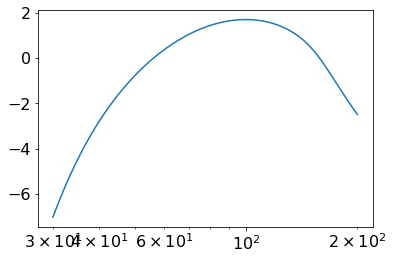

In [60]:
plt.plot(x, surrogate.eval_sur(2))
plt.xscale('log')

In [61]:
# validate the current basis

model_validation_q_array = np.random.uniform(1, 10, 1000)
_, model_validation_ts, model_validation_ts_coords = gen_1d_massratio_data(model_validation_q_array, 100)


model_errors = []
for i in range(len(model_validation_q_array)):
    q = model_validation_q_array[i]
    sur = surrogate.eval_sur(q)
    vts = model_validation_ts[i]
    error = surrogate.grb.integration.norm(vts - sur)**2
    model_errors.append(error)
model_errors = np.array(model_errors)
    
max_idx = np.argmax(model_errors)
print(max_idx)
print(model_validation_q_array[max_idx])
worst_q = model_validation_q_array[max_idx]

567
1.508882237994588


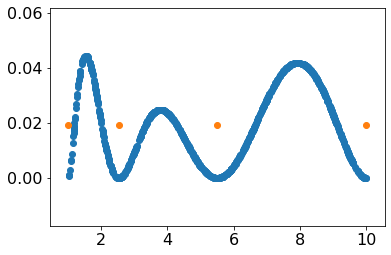

In [62]:
plt.figure()
plt.scatter(model_validation_q_array, model_errors)
plt.scatter(surrogate.grb.greedy_points, np.ones(surrogate.grb.nbasis)*np.mean(model_errors))

In [66]:
surrogate.run_iter(verbose=False)

worst case = 8.017128036438756
building EIM
fitting EIM


In [67]:
# validate the current basis

model_validation_q_array = np.random.uniform(1, 10, 1000)
_, model_validation_ts, model_validation_ts_coords = gen_1d_massratio_data(model_validation_q_array, 100)


model_errors = []
for i in range(len(model_validation_q_array)):
    q = model_validation_q_array[i]
    sur = surrogate.eval_sur(q)
    vts = model_validation_ts[i]
    error = surrogate.grb.integration.norm(vts - sur)**2
    model_errors.append(error)
model_errors = np.array(model_errors)
    
max_idx = np.argmax(model_errors)
print(max_idx)
print(model_validation_q_array[max_idx])
worst_q = model_validation_q_array[max_idx]

177
1.1654642876711998


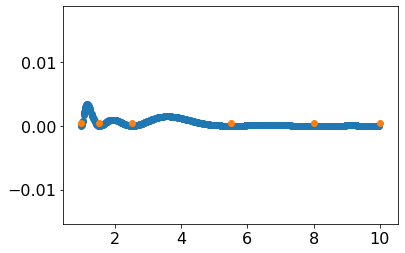

In [68]:
plt.figure()
plt.scatter(model_validation_q_array, model_errors)
plt.scatter(surrogate.grb.greedy_points, np.ones(surrogate.grb.nbasis)*np.mean(model_errors))

In [69]:
surrogate.grb.nbasis

6

In [70]:
surrogate.grb.greedy_points

array([[ 1.        ],
       [ 5.5       ],
       [10.        ],
       [ 2.53992775],
       [ 1.54138579],
       [ 8.01712804]])

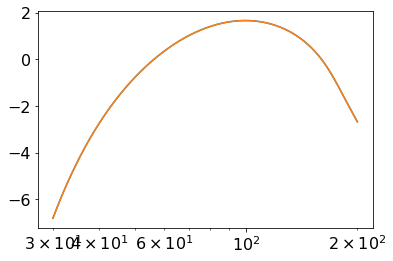

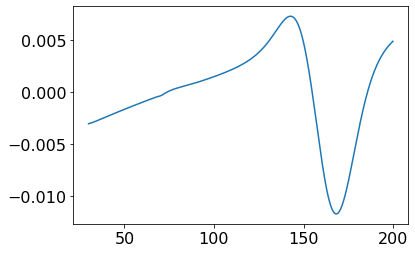

In [71]:
plt.figure()

i=max_idx
sur = surrogate.eval_sur(model_validation_q_array[i])
vts = model_validation_ts[i]
plt.plot(x, vts)
plt.plot(x, sur)
plt.xscale('log')
plt.show()
plt.close()

plt.figure()
plt.plot(x, vts-sur)
plt.show()
plt.close()

In [72]:
%%timeit
sur = surrogate.eval_sur(model_validation_q_array[i])

333 µs ± 3.85 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [24]:
%%timeit
_, model_validation_ts, model_validation_ts_coords = gen_1d_massratio_data([model_validation_q_array[i]], 100)

528 µs ± 9.55 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
